In [38]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc
import save_load_data as sldat


In [39]:
# Now, load the data
dt=0.01
robData = sldat.load_object('imu_test', folder=r"D:\msc_data")

# get number of robots
robot_N = robData.ids.shape[0]
# Get number of runs
runs_N = robData.biases.shape[2]
# Get length of runs 
pos_N = robData.pos.shape[2]
# get anchors
anchors = robData.anchors
colors = ['blue', 'red', 'green']

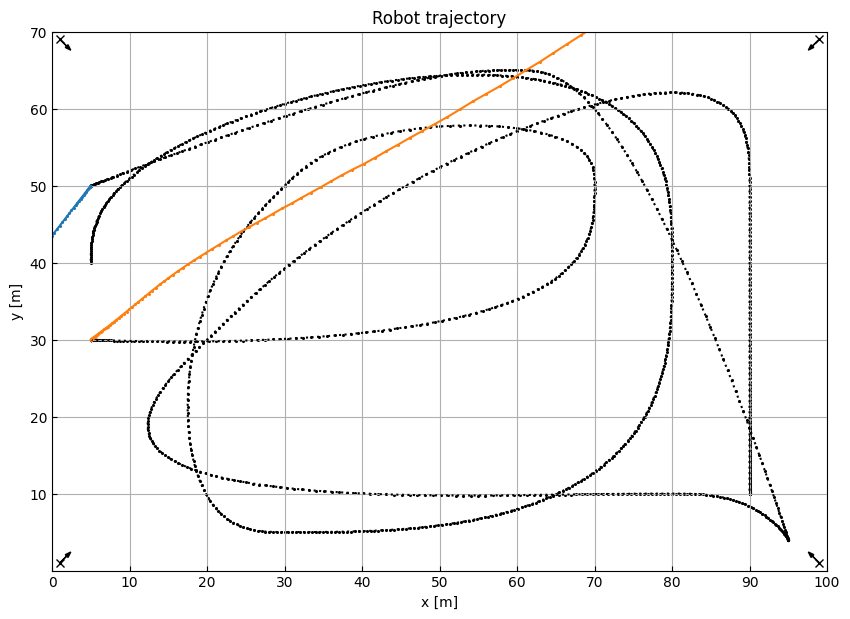

In [40]:
# And plot:
s_idx = 0

fig, ax = rp.setup_plot()
# Plot ground truth
for i in range(robot_N):
    rp.plot_position(ax, robData.pos[i,:,::100], color='black', marker=None, linestyle=':', draw_arrow=False, label='Robot 1 reference') # fix label

# Plot states of robots:
for i in range(robot_N):
    rp.plot_position2(ax, robData.x_log[i,:,::100,s_idx], None, color=None, marker=None, draw_arrow=False, label='Robot 1 trajectory')
    # P_log3[:,:,::100,s_idx]

# Plot anchor positions
for anc in anchors:
    anc.draw_position(ax=ax, color='black')


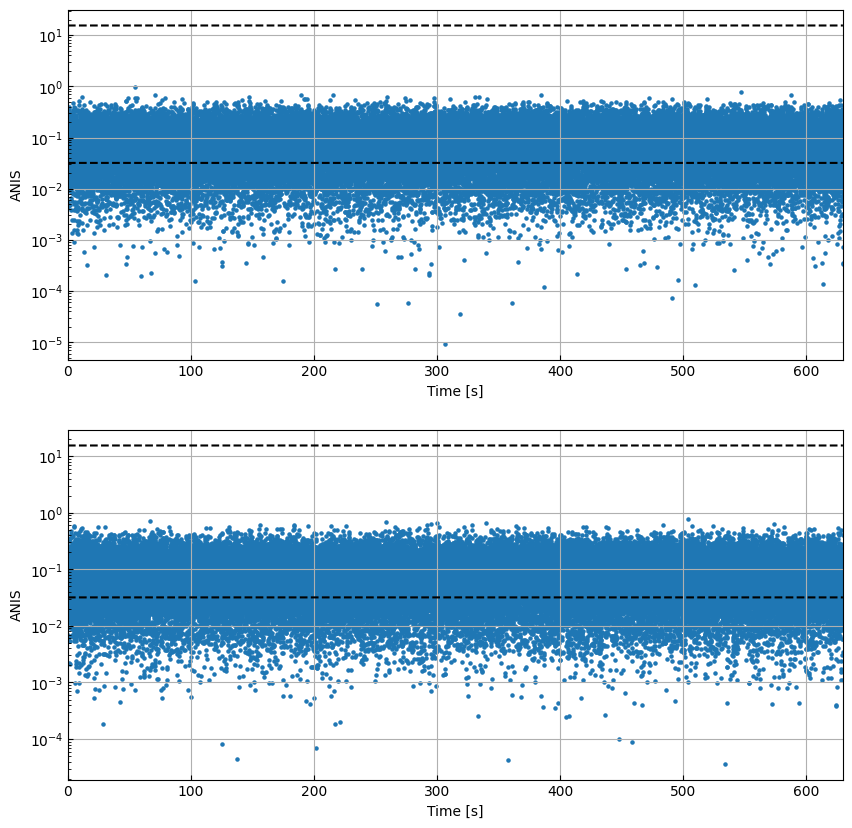

In [41]:
# ANIS analysis
fig, axnis = plt.subplots(robot_N, figsize=(10,10))
# Three df
for i in range(robot_N):
    rp.plot_ANIS(ax=axnis[i], nis=robData.IMU_nis_log[i] , df=3, dt=dt, prob=0.997, color=None)

IndexError: index 2 is out of bounds for axis 0 with size 2

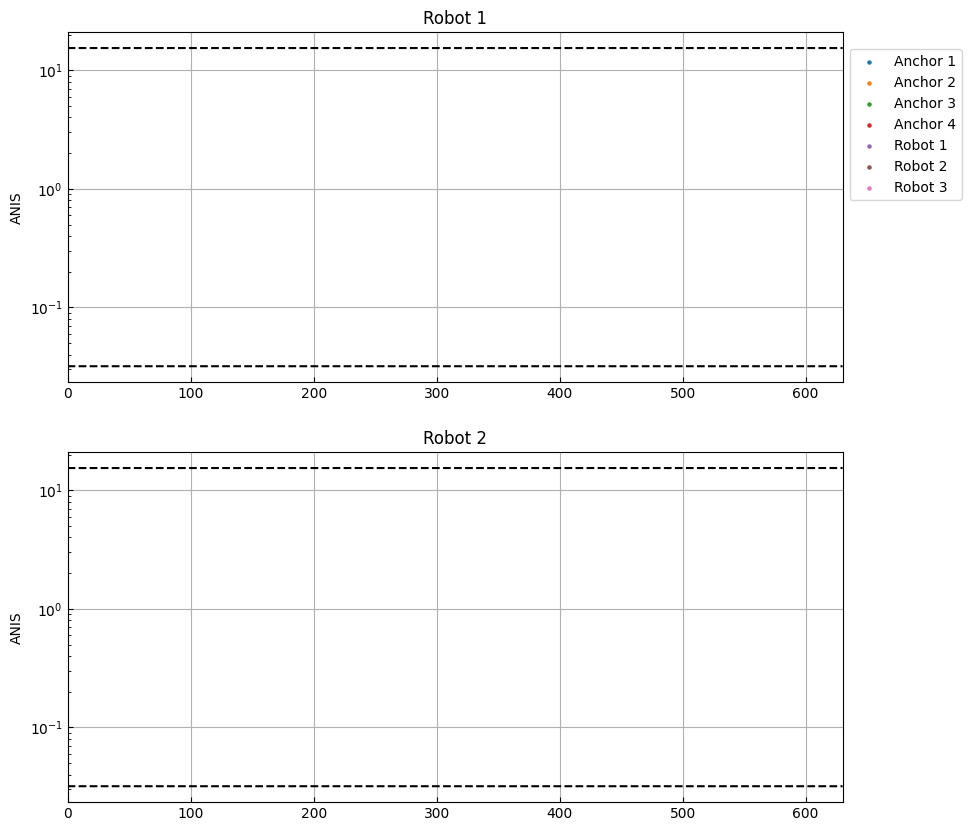

In [42]:
# ANIS analysis
fig, axnis = plt.subplots(robot_N, figsize=(10,10))
# Three df
df = 3
for i in range(robot_N):
    rp.plot_ANIS_rb(ax=axnis[i], 
                nis=robData.RB_nis_log[i], 
                rb_ids=robData.rb_ids[i], 
                pos_ids=[1, 2, 3, 4, 111, 222, 333], 
                labels=['Anchor 1', 'Anchor 2', 'Anchor 3', 'Anchor 4', 'Robot 1', 'Robot 2', 'Robot 3'],
                df=df, 
                dt=dt, 
                prob=0.997)

axnis[0].legend(loc='lower left', bbox_to_anchor=(1, 0.5))
axnis[0].set_xlabel(None)
axnis[1].set_xlabel(None)
axnis[0].set_title('Robot 1')
axnis[1].set_title('Robot 2')
axnis[2].set_title('Robot 3')

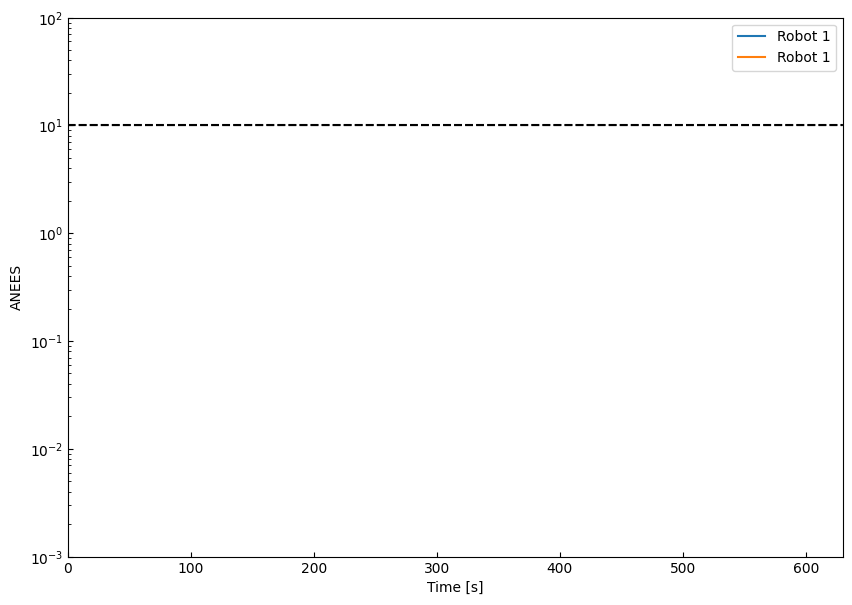

In [ ]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, ax_anees = plt.subplots(1, figsize=(10,7))
#anees_sel = np.array([[True],[False],[False]])
#pos_ind = [0, 2, 3]
#anees_sel = np.array([[False],[False]])
#pos_ind = [2, 3]
anees_sel = np.array([[True]])
pos_ind = [0]
for i in range(robot_N):
    rp.plot_ANEES(ax_anees, 
             x_est=robData.x_log[i, pos_ind,:,0:1],
             x_true=robData.pos[i,0:1,:], 
             P = robData.P_log[i][pos_ind][:, pos_ind, :, 0:1],
             rad_sel=anees_sel,
             dt=dt,
             prob=0.997,
             color=None,
             label='Robot 1')

#ax_anees.set_ylim([0.001, 100])

ax_anees.legend()

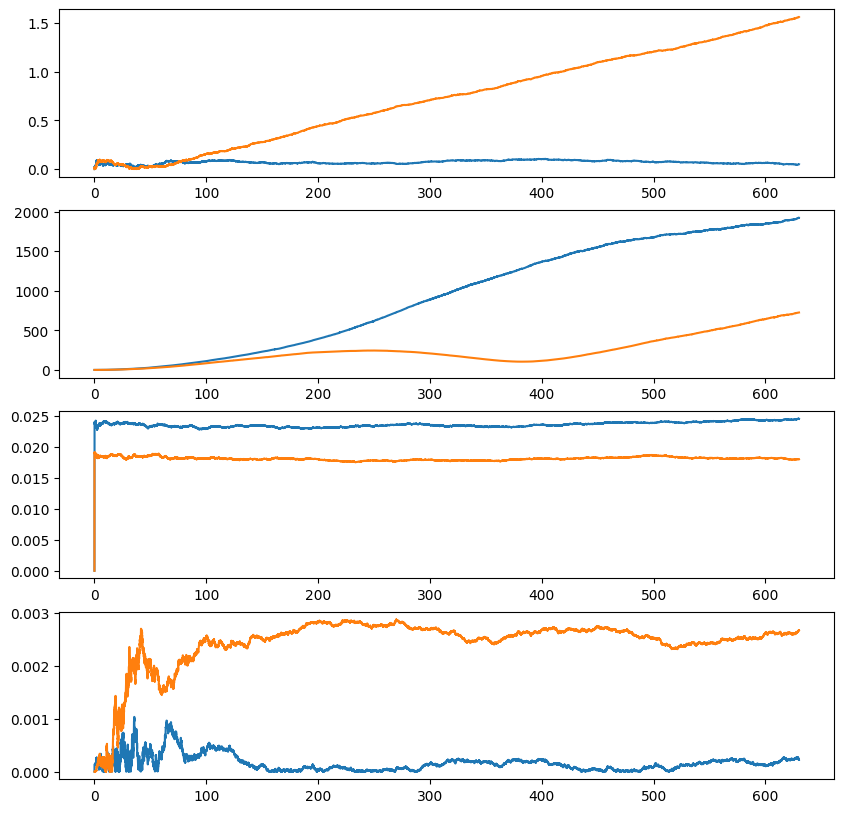

In [ ]:
# Calculate the errors
rad_sel = np.repeat(np.array([[True],[False],[False]]), pos_N, axis=1)
pos_ind = [0, 2, 3]
bias_ind = [8, 9, 10]

err_pos = np.zeros((robot_N, 3, pos_N, runs_N))
err_bias = np.zeros((robot_N, 3, pos_N, runs_N))
t = np.linspace(0, pos_N*dt, pos_N)

for i in range(robot_N):
    for j in range(runs_N):
        err_pos[i,:,:,j] = mf.subtractState(robData.pos[i], robData.x_log[i, pos_ind,:, j], rad_sel) 
        err_bias[i,:,:,j] = mf.subtractState(  np.repeat(robData.biases[i,:,j:j+1], pos_N, axis=1)  , robData.x_log[i, bias_ind,:, j], rad_sel)

# Then calculate the norms
pos_abs =  (1/runs_N)*np.sum(np.linalg.norm(err_pos[:,1:], axis=1), axis=2)
or_abs = (1/runs_N)*np.sum(abs(err_pos[:,0]), axis=2)

bias_acc_abs = (1/runs_N)*np.sum(np.linalg.norm(err_bias[:,1:], axis=1), axis=2)
bias_w_abs = (1/runs_N)*np.sum(abs(err_bias[:,0]), axis=2)

# Plot absolute error
fig, axerr = plt.subplots(4, figsize=(10,10))
for i in range(robot_N):
    axerr[0].plot(t, or_abs[i,:], label=("UAV " + str(i)))
    axerr[1].plot(t, pos_abs[i,:], label=("UAV " + str(i)))
    axerr[2].plot(t, bias_acc_abs[i,:], label=("UAV " + str(i)))
    axerr[3].plot(t, bias_w_abs[i,:], label=("UAV " + str(i)))
